# Recommendation Systems

This notebook implements and explores different recommender systems for recommending movies to users using the MovieLens 100k dataset.

The following recommender systems are implemented:

* Popularity-based Baseline Recommender System
* User-average-based Baseline Recommender System
* User-based Collaborative Filtering
* Item-based Collaborative Filtering
* Probablistic Matrix Factorization (PMF)
* Improved PMF



### Imports

In [ ]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import wget
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=847e0cfce11770ae1b343a0598908999c45536a174660d662cc73a3423b52d5c
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


## Support functions and variables

In [ ]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")

'ml-100k.zip'

In [ ]:
!unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [ ]:
MOVIELENS_DIR = "ml-100k"

In [ ]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [ ]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data

In [ ]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [ ]:
rating_df_train = getData(MOVIELENS_DIR, 'u1.base')
rating_df_test = getData(MOVIELENS_DIR, 'u1.test')

In [ ]:
rating_df_train.head()

,userID,itemID,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [ ]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [ ]:
print("Number of users in rating df:", len(rating_df.userID.unique()))
print("Number of items in rating df:", len(rating_df.itemID.unique()))
print("Number of users in train df:", len(rating_df_train.userID.unique()))
print("Number of items in train df:", len(rating_df_train.itemID.unique()))
print("Number of users in test df:", len(rating_df_test.userID.unique()))
print("Number of items in test df:", len(rating_df_test.itemID.unique()))

Number of users in rating df: 943
Number of items in rating df: 1682
Number of users in train df: 943
Number of items in train df: 1650
Number of users in test df: 459
Number of items in test df: 1410


## Data Preprocessing

In [ ]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT:
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items

        OUTPUT:
            matrix: 2D numpy array.

        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'

        NOTE 2: data can have more columns, but your function should ignore
              additional columns.
    """

    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)

    # Populate the matrix based on the dataset
    for row in rating_df.itertuples():
        userID = row.userID
        itemID = row.itemID
        rating = row.rating

        # Populate the matrix
        matrix[userID-1, itemID-1] = rating

    return matrix

In [ ]:
a = dataPreprocessor(rating_df,  len(rating_df.userID.unique()),  len(rating_df.itemID.unique()))
print(a.shape)

(943, 1682)


## Baseline Recommender System

In [ ]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name

    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }

        return switcher[method_name]

    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.

            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'
        """

        predictionMatrix = np.zeros((num_users, num_items))

        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                # select the row for user
                # what's the shape of userVector
                userVector = train_matrix[user, :]

                # Extract the items the user already rated
                ratedItems = userVector[userVector.nonzero()]

                # If not empty, calculate average and set as rating for the current item
                if ratedItems.size == 0:
                    itemAvg = 0
                else:
                    itemAvg = ratedItems.mean()
                predictionMatrix[user, item] = itemAvg

        return predictionMatrix

    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.

            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'
        """

        predictionMatrix = np.zeros((num_users, num_items))

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated

        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]

        return predictionMatrix

    def predict_all(self, train_df, num_users, num_items):

        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)

    def evaluate_test(self, test_df, copy=False):

        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df

        prediction[self.pred_column_name] = np.nan

        for (index,
             userID,
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction

    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model

    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name

    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")


### Popularity-based Baseline Recommender System

In [ ]:
popularity_recsys = BaseLineRecSys('popularity')

In [ ]:
popularity_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))


In [ ]:
x = popularity_recsys.getModel()

In [ ]:
x

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.38095238, 0.37333333, ..., 0.        , 0.        ,
        0.        ],
       [0.71018277, 0.38095238, 0.37333333, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.38095238, 0.37333333, ..., 0.        , 0.        ,
        0.        ],
       [0.71018277, 0.38095238, 0.37333333, ..., 0.        , 0.        ,
        0.        ],
       [0.71018277, 0.        , 0.37333333, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
np.all(x<=1)

True

In [ ]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [ ]:
popularity_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:04, 4872.55it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


### User-average-based Baseline Recommender System

In [ ]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [ ]:
average_user_rating_recsys.predict_all(rating_df_train, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

In [ ]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.68148148, 3.68148148,
        3.68148148],
       [0.        , 3.8       , 3.8       , ..., 3.8       , 3.8       ,
        3.8       ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [ ]:
average_user_rating_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:01, 12285.43it/s]


,userID,itemID,rating,timestamp,useraverage
0,1,6,5,887431973,3.681481
1,1,10,3,875693118,3.681481
2,1,12,5,878542960,3.681481
3,1,14,5,874965706,3.681481
4,1,17,3,875073198,3.681481


## Similarity in Collaborative Filtering

In [ ]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name

    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }

        return switcher[method_name]

    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix

    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        distance_matrix = pairwise_distances(matrix, metric='euclidean')
        similarity_matrix = 1 / (1 + distance_matrix)

        return similarity_matrix

    @staticmethod
    def somethingelse(matrix):
        """
            manhattan similarity
        """
        distance_matrix = pairwise_distances(matrix, metric='manhattan')
        similarity_matrix = 1 / (1 + distance_matrix)

        return similarity_matrix

    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model

            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)

        if self.base == 'user':
            # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)

            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5

            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer

            # Cold start
            # if no one has rated this item before, use user average
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)

            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix

        elif self.base == 'item':
            # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            # Transpose the matrix for item-item similarity
            ii_similarity = self.method(train_matrix.T)

            normalizer = np.matmul(temp_matrix, ii_similarity)
            normalizer[normalizer == 0] = 1e-5

            predictionMatrix = np.matmul(train_matrix, ii_similarity)/normalizer

            itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
            rows = np.sum(predictionMatrix, axis=1)

            predictionMatrix[rows==0, :] = predictionMatrix[rows==0, :] + np.expand_dims(itemaverage, axis=0)
            self.__model = predictionMatrix
        else:
            print('No other option available')

    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame.
                              columns=['userID', 'itemID', 'rating', 'base-method'...]

            NOTE: 1. data can have more columns, but your function should ignore
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine',
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan

        for (index,
             userID,
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction

    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model

    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name

    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [ ]:
# Examples of how to call similarity functions.
#I = np.eye(3)
I = np.array([[3,0,2, 3],[0,5,3, 4], [3,3,5, 1], [0,5,0, 0], [3,5,0, 3]])
print(I[[True,False, False, True, True]])

[[3 0 2 3]
 [0 5 0 0]
 [3 5 0 3]]


In [ ]:
SimBasedRecSys.cosine(I)

array([[1.        , 0.54272042, 0.70710678, 0.        , 0.58523048],
       [0.54272042, 1.        , 0.72488244, 0.70710678, 0.79796252],
       [0.70710678, 0.72488244, 1.        , 0.45226702, 0.62073066],
       [0.        , 0.70710678, 0.45226702, 1.        , 0.76249285],
       [0.58523048, 0.79796252, 0.62073066, 0.76249285, 1.        ]])

In [ ]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.14285714, 0.17573408, 0.12729684, 0.15661303],
       [0.14285714, 1.        , 0.16396078, 0.16666667, 0.1866055 ],
       [0.17573408, 0.16396078, 1.        , 0.13802626, 0.14826758],
       [0.12729684, 0.16666667, 0.13802626, 1.        , 0.19074357],
       [0.15661303, 0.1866055 , 0.14826758, 0.19074357, 1.        ]])

In [ ]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.09090909, 0.11111111, 0.07142857, 0.125     ],
       [0.09090909, 1.        , 0.09090909, 0.125     , 0.125     ],
       [0.11111111, 0.09090909, 1.        , 0.08333333, 0.1       ],
       [0.07142857, 0.125     , 0.08333333, 1.        , 0.14285714],
       [0.125     , 0.125     , 0.1       , 0.14285714, 1.        ]])

### User-based Collaborative Filtering

In [ ]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [ ]:
user_cosine_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))


In [ ]:
user_cosine_recsys.getModel()


array([[3.90764656, 3.18309825, 3.00989335, ..., 2.        , 3.        ,
        3.        ],
       [3.85592514, 3.18240388, 2.89077623, ..., 2.        , 3.        ,
        3.        ],
       [3.87394327, 3.10905007, 3.02102791, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.92534088, 3.20099215, 3.04206385, ..., 2.        , 3.        ,
        3.        ],
       [3.90921865, 3.21359819, 2.9819897 , ..., 2.        , 3.        ,
        3.        ],
       [3.93355541, 3.24681066, 3.05886723, ..., 0.        , 3.        ,
        3.        ]])

In [ ]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [ ]:
user_cosine_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:01, 11751.91it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,6,5,887431973,3.419572
1,1,10,3,875693118,3.850140
2,1,12,5,878542960,4.400558
3,1,14,5,874965706,3.878056
4,1,17,3,875073198,3.130335


### Item-based Collaborative Filtering

In [ ]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [ ]:
item_cosine_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)


In [ ]:
item_cosine_recsys.getModel()

array([[3.85156994, 3.7342213 , 3.83843022, ..., 4.11798149, 3.90551101,
        3.9598337 ],
       [3.87401875, 3.85300753, 3.82228493, ..., 3.77601163, 3.95744705,
        4.09365253],
       [2.96947266, 3.03381501, 2.94253433, ..., 3.12417711, 3.27065656,
        2.79578581],
       ...,
       [4.11724041, 4.06618477, 4.0274836 , ..., 4.        , 3.88126854,
        4.14874911],
       [4.37234448, 4.42355222, 4.34195687, ..., 3.95265019, 4.41470077,
        4.57717283],
       [3.52291931, 3.4890315 , 3.53459055, ..., 0.        , 3.608216  ,
        3.59916709]])

In [ ]:
item_cosine_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:01, 12055.32it/s]


,userID,itemID,rating,timestamp,item-cosine
0,1,6,5,887431973,4.047083
1,1,10,3,875693118,3.976599
2,1,12,5,878542960,3.889206
3,1,14,5,874965706,4.024444
4,1,17,3,875073198,3.779897


### Cross Validation Results

In [ ]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)

    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
            'RPrecision': self.rprecision
        }

        return switcher[metric_name]

    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))

    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)

        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions

    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls

    def rprecision(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet = self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRPs = 0
        countRPs = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID, :]


            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID, :]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            topK = nlargest(len(userTestVector), range(len(userVector)), userVector.take)
            # Calculate recall
            rp = float(len([item for item in topK if item in userTestVector])) / len(userTestVector)

            # Update sum and count
            sumRPs += rp
            countRPs += 1

        # Return average R@k
        return float(sumRPs) / countRPs

    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))

        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value

        return matrix

    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds

    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms.
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """

        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))

            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]

        results = scores

        return results


In [ ]:
# Cross Validation results with RMSE evaluation metric

algorithm_instances = [user_cosine_recsys,
                       item_cosine_recsys]

cv_rmse = CrossValidation('RMSE')
cv_rmse.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)

Processing algorithm user-cosine


20000it [00:02, 7648.35it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,6,5,887431973,3.419572
1,1,10,3,875693118,3.850140
2,1,12,5,878542960,4.400558
3,1,14,5,874965706,3.878056
4,1,17,3,875073198,3.130335


20000it [00:01, 12136.38it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,1,5,874965758,3.913834
1,1,2,3,876893171,3.253514
2,1,8,1,875072484,3.980843
3,1,9,5,878543541,3.937285
4,1,21,1,878542772,2.771853


20000it [00:01, 12201.88it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,5,3,889751712,3.240668
1,1,11,2,875072262,3.893246
2,1,16,5,878543541,3.215255
3,1,25,4,875071805,3.319303
4,1,35,1,878542420,2.059214


20000it [00:01, 11828.24it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,4,3,876893119,3.627681
1,1,7,4,875071561,3.836359
2,1,42,5,876892425,3.749918
3,1,43,4,878542869,2.936146
4,1,55,5,875072688,3.719798


20000it [00:01, 11784.18it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,3,4,878542960,2.990268
1,1,13,5,875071805,3.407021
2,1,15,5,875071608,3.707102
3,1,18,4,887432020,3.107031
4,1,19,5,875071515,3.798918


Processing algorithm item-cosine


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
20000it [00:02, 6991.15it/s]


,userID,itemID,rating,timestamp,user-cosine,item-cosine
0,1,6,5,887431973,3.419572,4.047083
1,1,10,3,875693118,3.850140,3.976599
2,1,12,5,878542960,4.400558,3.889206
3,1,14,5,874965706,3.878056,4.024444
4,1,17,3,875073198,3.130335,3.779897


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
20000it [00:02, 8846.73it/s]


,userID,itemID,rating,timestamp,user-cosine,item-cosine
0,1,1,5,874965758,3.913834,3.765157
1,1,2,3,876893171,3.253514,3.680153
2,1,8,1,875072484,3.980843,3.790145
3,1,9,5,878543541,3.937285,3.845202
4,1,21,1,878542772,2.771853,3.625862


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
20000it [00:02, 8885.01it/s]


,userID,itemID,rating,timestamp,user-cosine,item-cosine
0,1,5,3,889751712,3.240668,3.626623
1,1,11,2,875072262,3.893246,3.710390
2,1,16,5,878543541,3.215255,3.801815
3,1,25,4,875071805,3.319303,3.707672
4,1,35,1,878542420,2.059214,3.183574


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
20000it [00:02, 9293.67it/s]


,userID,itemID,rating,timestamp,user-cosine,item-cosine
0,1,4,3,876893119,3.627681,3.740978
1,1,7,4,875071561,3.836359,3.768802
2,1,42,5,876892425,3.749918,3.771590
3,1,43,4,878542869,2.936146,3.595493
4,1,55,5,875072688,3.719798,3.741365


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
20000it [00:02, 7710.20it/s]


,userID,itemID,rating,timestamp,user-cosine,item-cosine
0,1,3,4,878542960,2.990268,3.684890
1,1,13,5,875071805,3.407021,3.848399
2,1,15,5,875071608,3.707102,3.702558
3,1,18,4,887432020,3.107031,3.877299
4,1,19,5,875071515,3.798918,4.006506


{'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022947,
   1.0161883961525586],
  1.0173541216605808,
  1.009013080226148,
  1.0256951630950135],
 'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226]}

From the averages and confidence intervals of the RMSE between the user-user and item-item based collaborative filtering (CBF) with cosine similarity, it can be seen that they performed basically the same (their confidence intervals overlap so it would be hard to really say which one performed better). This could be because the average number of ratings per user is roughly the same compared to the average number of ratings per item.

## Probablistic Matrix Factorization (PMF)

In [ ]:
import sys
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)

        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors

        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item

            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user

        """
        # select 'userID', 'itemID', 'rating only
        train_vec['userID'] = train_vec['userID']
        train_vec['itemID'] = train_vec['itemID']
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating


        # to avoid out of bound
        num_user += 1
        num_item += 1
        # initialize
        self.epoch = 0
        self.w_Item = 0.1 * np.random.randn(num_item, self.num_feat)
        self.w_User = 0.1 * np.random.randn(num_user, self.num_feat)

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient

        while self.epoch < self.maxepoch:
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches):
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')


                # Compute mean rating subtracted rating
                pred_out = None #size (batch_size, )
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :], self.w_Item[batch_ItemID, :]), axis=1)

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')

                    # Compute Compute mean rating subtracted rating
                    pred_out = None # size(pairs_train, )
                    pred_out = np.sum(np.multiply(self.w_User[train_user_idx, :], self.w_Item[train_item_idx, :]), axis=1)

                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2]
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')

                    # Compute Compute mean rating subtracted rating
                    pred_out = pred_out = None #size(pairs_val, )
                    pred_out = np.sum(np.multiply(self.w_User[val_user_idx, :], self.w_Item[val_item_idx, :]), axis=1)

                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))

    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame.
                              columns=['userID', 'itemID', 'rating', 'base-method'...]

            NOTE: 1. data can have more columns, but your function should ignore
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine',
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        # prediction['userID'] = prediction['userID'] - 1
        # prediction['itemID'] = prediction['itemID'] - 1
        prediction[self.pred_column_name] = np.nan

        for (index,
             userID,
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]

        return prediction

    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()

    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name

    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None
            self.w_User = None
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)
        else:
          raise Exception("You need to pass in a dictionary")

In [ ]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 100, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})

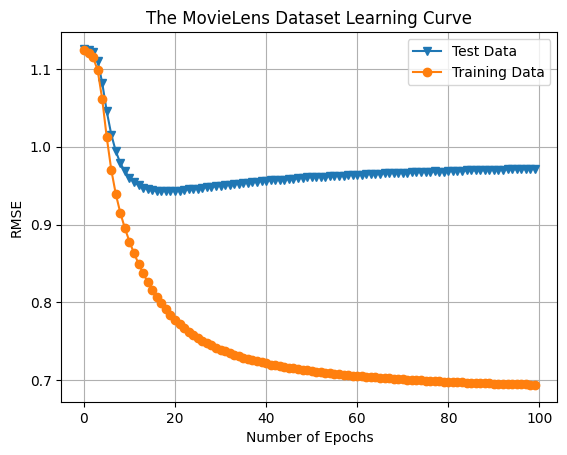

In [ ]:
pmf.predict_all(rating_df,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
pmf.plot_error()

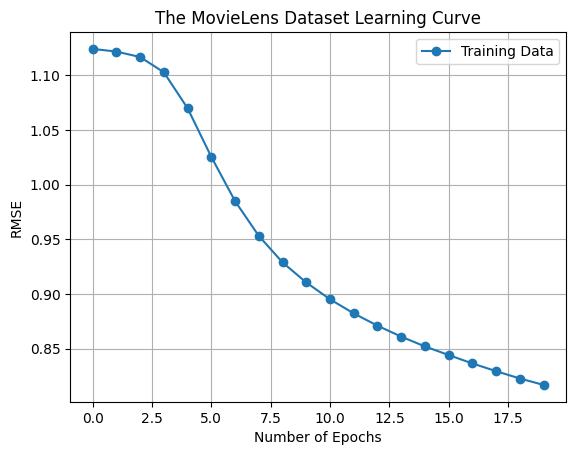

In [ ]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 20, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})
pmf.predict_all(rating_df,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
pmf.plot_error()

## Performance Comparison

In [ ]:
# Evaluation using RMSE
algorithm_instances = [popularity_recsys,
                       average_user_rating_recsys,
                       user_cosine_recsys,
                       item_cosine_recsys,
                       pmf]

cv_rmse = CrossValidation('RMSE')
rmse_res = cv_rmse.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)

Processing algorithm popularity


20000it [00:01, 12132.13it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


20000it [00:01, 12291.88it/s]


,userID,itemID,rating,timestamp,popularity
0,1,1,5,874965758,0.717877
1,1,2,3,876893171,0.401869
2,1,8,1,875072484,0.691429
3,1,9,5,878543541,0.698795
4,1,21,1,878542772,0.206349


20000it [00:01, 12407.95it/s]


,userID,itemID,rating,timestamp,popularity
0,1,5,3,889751712,0.454545
1,1,11,2,875072262,0.717277
2,1,16,5,878543541,0.413793
3,1,25,4,875071805,0.497908
4,1,35,1,878542420,0.222222


20000it [00:01, 12147.97it/s]


,userID,itemID,rating,timestamp,popularity
0,1,4,3,876893119,0.630303
1,1,7,4,875071561,0.671975
2,1,42,5,876892425,0.632000
3,1,43,4,878542869,0.200000
4,1,55,5,875072688,0.647619


20000it [00:01, 12385.76it/s]


,userID,itemID,rating,timestamp,popularity
0,1,3,4,878542960,0.342466
1,1,13,5,875071805,0.496732
2,1,15,5,875071608,0.627049
3,1,18,4,887432020,0.250000
4,1,19,5,875071515,0.705882


Processing algorithm useraverage


20000it [00:02, 9311.66it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,6,5,887431973,0.500000,3.681481
1,1,10,3,875693118,0.698630,3.681481
2,1,12,5,878542960,0.872038,3.681481
3,1,14,5,874965706,0.685714,3.681481
4,1,17,3,875073198,0.472222,3.681481


20000it [00:02, 9093.08it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,1,5,874965758,0.717877,3.633028
1,1,2,3,876893171,0.401869,3.633028
2,1,8,1,875072484,0.691429,3.633028
3,1,9,5,878543541,0.698795,3.633028
4,1,21,1,878542772,0.206349,3.633028


20000it [00:02, 8958.69it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,5,3,889751712,0.454545,3.575107
1,1,11,2,875072262,0.717277,3.575107
2,1,16,5,878543541,0.413793,3.575107
3,1,25,4,875071805,0.497908,3.575107
4,1,35,1,878542420,0.222222,3.575107


20000it [00:02, 9224.40it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,4,3,876893119,0.630303,3.59761
1,1,7,4,875071561,0.671975,3.59761
2,1,42,5,876892425,0.632000,3.59761
3,1,43,4,878542869,0.200000,3.59761
4,1,55,5,875072688,0.647619,3.59761


20000it [00:02, 9471.84it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,3,4,878542960,0.342466,3.59761
1,1,13,5,875071805,0.496732,3.59761
2,1,15,5,875071608,0.627049,3.59761
3,1,18,4,887432020,0.250000,3.59761
4,1,19,5,875071515,0.705882,3.59761


Processing algorithm user-cosine


20000it [00:02, 8915.35it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,6,5,887431973,0.500000,3.681481,3.419572
1,1,10,3,875693118,0.698630,3.681481,3.850140
2,1,12,5,878542960,0.872038,3.681481,4.400558
3,1,14,5,874965706,0.685714,3.681481,3.878056
4,1,17,3,875073198,0.472222,3.681481,3.130335


20000it [00:03, 6141.21it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,1,5,874965758,0.717877,3.633028,3.913834
1,1,2,3,876893171,0.401869,3.633028,3.253514
2,1,8,1,875072484,0.691429,3.633028,3.980843
3,1,9,5,878543541,0.698795,3.633028,3.937285
4,1,21,1,878542772,0.206349,3.633028,2.771853


20000it [00:02, 9099.36it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,5,3,889751712,0.454545,3.575107,3.240668
1,1,11,2,875072262,0.717277,3.575107,3.893246
2,1,16,5,878543541,0.413793,3.575107,3.215255
3,1,25,4,875071805,0.497908,3.575107,3.319303
4,1,35,1,878542420,0.222222,3.575107,2.059214


20000it [00:02, 9022.75it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,4,3,876893119,0.630303,3.59761,3.627681
1,1,7,4,875071561,0.671975,3.59761,3.836359
2,1,42,5,876892425,0.632000,3.59761,3.749918
3,1,43,4,878542869,0.200000,3.59761,2.936146
4,1,55,5,875072688,0.647619,3.59761,3.719798


20000it [00:02, 9010.57it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,3,4,878542960,0.342466,3.59761,2.990268
1,1,13,5,875071805,0.496732,3.59761,3.407021
2,1,15,5,875071608,0.627049,3.59761,3.707102
3,1,18,4,887432020,0.250000,3.59761,3.107031
4,1,19,5,875071515,0.705882,3.59761,3.798918


Processing algorithm item-cosine


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
20000it [00:02, 6940.77it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,6,5,887431973,0.500000,3.681481,3.419572,4.047083
1,1,10,3,875693118,0.698630,3.681481,3.850140,3.976599
2,1,12,5,878542960,0.872038,3.681481,4.400558,3.889206
3,1,14,5,874965706,0.685714,3.681481,3.878056,4.024444
4,1,17,3,875073198,0.472222,3.681481,3.130335,3.779897


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
20000it [00:02, 8444.58it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,1,5,874965758,0.717877,3.633028,3.913834,3.765157
1,1,2,3,876893171,0.401869,3.633028,3.253514,3.680153
2,1,8,1,875072484,0.691429,3.633028,3.980843,3.790145
3,1,9,5,878543541,0.698795,3.633028,3.937285,3.845202
4,1,21,1,878542772,0.206349,3.633028,2.771853,3.625862


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
20000it [00:02, 8833.82it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,5,3,889751712,0.454545,3.575107,3.240668,3.626623
1,1,11,2,875072262,0.717277,3.575107,3.893246,3.710390
2,1,16,5,878543541,0.413793,3.575107,3.215255,3.801815
3,1,25,4,875071805,0.497908,3.575107,3.319303,3.707672
4,1,35,1,878542420,0.222222,3.575107,2.059214,3.183574


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
20000it [00:02, 9086.15it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,4,3,876893119,0.630303,3.59761,3.627681,3.740978
1,1,7,4,875071561,0.671975,3.59761,3.836359,3.768802
2,1,42,5,876892425,0.632000,3.59761,3.749918,3.771590
3,1,43,4,878542869,0.200000,3.59761,2.936146,3.595493
4,1,55,5,875072688,0.647619,3.59761,3.719798,3.741365


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
20000it [00:02, 7701.55it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,3,4,878542960,0.342466,3.59761,2.990268,3.684890
1,1,13,5,875071805,0.496732,3.59761,3.407021,3.848399
2,1,15,5,875071608,0.627049,3.59761,3.707102,3.702558
3,1,18,4,887432020,0.250000,3.59761,3.107031,3.877299
4,1,19,5,875071515,0.705882,3.59761,3.798918,4.006506


Processing algorithm PMF


20000it [00:05, 3391.53it/s]


,userID,itemID,rating,PMF
0,1,6,5,3.476139
1,1,10,3,4.159233
2,1,12,5,4.792976
3,1,14,5,4.005487
4,1,17,3,3.235518


20000it [00:05, 3450.31it/s]


,userID,itemID,rating,PMF
0,1,1,5,4.172854
1,1,2,3,3.157264
2,1,8,1,4.178521
3,1,9,5,4.155456
4,1,21,1,2.325154


20000it [00:05, 3402.81it/s]


,userID,itemID,rating,PMF
0,1,5,3,2.885344
1,1,11,2,4.056530
2,1,16,5,3.041485
3,1,25,4,3.157959
4,1,35,1,2.518396


20000it [00:05, 3353.66it/s]


,userID,itemID,rating,PMF
0,1,4,3,4.100913
1,1,7,4,4.148131
2,1,42,5,3.394352
3,1,43,4,2.897185
4,1,55,5,4.033304


20000it [00:05, 3919.62it/s]


,userID,itemID,rating,PMF
0,1,3,4,3.184383
1,1,13,5,3.690121
2,1,15,5,3.082235
3,1,18,4,3.092930
4,1,19,5,4.498486


In [ ]:
# Evaluation using P@K
algorithm_instances = [popularity_recsys,
                       average_user_rating_recsys,
                       user_cosine_recsys,
                       item_cosine_recsys,
                       pmf]

cv_patk = CrossValidation('P@K')
pk_res = cv_patk.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)

Processing algorithm popularity


20000it [00:01, 12380.66it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


20000it [00:01, 12340.15it/s]


,userID,itemID,rating,timestamp,popularity
0,1,1,5,874965758,0.717877
1,1,2,3,876893171,0.401869
2,1,8,1,875072484,0.691429
3,1,9,5,878543541,0.698795
4,1,21,1,878542772,0.206349


20000it [00:02, 8469.90it/s]


,userID,itemID,rating,timestamp,popularity
0,1,5,3,889751712,0.454545
1,1,11,2,875072262,0.717277
2,1,16,5,878543541,0.413793
3,1,25,4,875071805,0.497908
4,1,35,1,878542420,0.222222


20000it [00:01, 12041.32it/s]


,userID,itemID,rating,timestamp,popularity
0,1,4,3,876893119,0.630303
1,1,7,4,875071561,0.671975
2,1,42,5,876892425,0.632000
3,1,43,4,878542869,0.200000
4,1,55,5,875072688,0.647619


20000it [00:01, 12170.62it/s]


,userID,itemID,rating,timestamp,popularity
0,1,3,4,878542960,0.342466
1,1,13,5,875071805,0.496732
2,1,15,5,875071608,0.627049
3,1,18,4,887432020,0.250000
4,1,19,5,875071515,0.705882


Processing algorithm useraverage


20000it [00:02, 9288.02it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,6,5,887431973,0.500000,3.681481
1,1,10,3,875693118,0.698630,3.681481
2,1,12,5,878542960,0.872038,3.681481
3,1,14,5,874965706,0.685714,3.681481
4,1,17,3,875073198,0.472222,3.681481


20000it [00:02, 9028.53it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,1,5,874965758,0.717877,3.633028
1,1,2,3,876893171,0.401869,3.633028
2,1,8,1,875072484,0.691429,3.633028
3,1,9,5,878543541,0.698795,3.633028
4,1,21,1,878542772,0.206349,3.633028


20000it [00:02, 8985.19it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,5,3,889751712,0.454545,3.575107
1,1,11,2,875072262,0.717277,3.575107
2,1,16,5,878543541,0.413793,3.575107
3,1,25,4,875071805,0.497908,3.575107
4,1,35,1,878542420,0.222222,3.575107


20000it [00:03, 6115.10it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,4,3,876893119,0.630303,3.59761
1,1,7,4,875071561,0.671975,3.59761
2,1,42,5,876892425,0.632000,3.59761
3,1,43,4,878542869,0.200000,3.59761
4,1,55,5,875072688,0.647619,3.59761


20000it [00:02, 9047.53it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,3,4,878542960,0.342466,3.59761
1,1,13,5,875071805,0.496732,3.59761
2,1,15,5,875071608,0.627049,3.59761
3,1,18,4,887432020,0.250000,3.59761
4,1,19,5,875071515,0.705882,3.59761


Processing algorithm user-cosine


20000it [00:02, 8944.26it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,6,5,887431973,0.500000,3.681481,3.419572
1,1,10,3,875693118,0.698630,3.681481,3.850140
2,1,12,5,878542960,0.872038,3.681481,4.400558
3,1,14,5,874965706,0.685714,3.681481,3.878056
4,1,17,3,875073198,0.472222,3.681481,3.130335


20000it [00:02, 7388.76it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,1,5,874965758,0.717877,3.633028,3.913834
1,1,2,3,876893171,0.401869,3.633028,3.253514
2,1,8,1,875072484,0.691429,3.633028,3.980843
3,1,9,5,878543541,0.698795,3.633028,3.937285
4,1,21,1,878542772,0.206349,3.633028,2.771853


20000it [00:02, 9086.89it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,5,3,889751712,0.454545,3.575107,3.240668
1,1,11,2,875072262,0.717277,3.575107,3.893246
2,1,16,5,878543541,0.413793,3.575107,3.215255
3,1,25,4,875071805,0.497908,3.575107,3.319303
4,1,35,1,878542420,0.222222,3.575107,2.059214


20000it [00:02, 8877.71it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,4,3,876893119,0.630303,3.59761,3.627681
1,1,7,4,875071561,0.671975,3.59761,3.836359
2,1,42,5,876892425,0.632000,3.59761,3.749918
3,1,43,4,878542869,0.200000,3.59761,2.936146
4,1,55,5,875072688,0.647619,3.59761,3.719798


20000it [00:03, 6425.87it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,3,4,878542960,0.342466,3.59761,2.990268
1,1,13,5,875071805,0.496732,3.59761,3.407021
2,1,15,5,875071608,0.627049,3.59761,3.707102
3,1,18,4,887432020,0.250000,3.59761,3.107031
4,1,19,5,875071515,0.705882,3.59761,3.798918


Processing algorithm item-cosine


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
20000it [00:02, 9004.33it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,6,5,887431973,0.500000,3.681481,3.419572,4.047083
1,1,10,3,875693118,0.698630,3.681481,3.850140,3.976599
2,1,12,5,878542960,0.872038,3.681481,4.400558,3.889206
3,1,14,5,874965706,0.685714,3.681481,3.878056,4.024444
4,1,17,3,875073198,0.472222,3.681481,3.130335,3.779897


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
20000it [00:02, 8998.56it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,1,5,874965758,0.717877,3.633028,3.913834,3.765157
1,1,2,3,876893171,0.401869,3.633028,3.253514,3.680153
2,1,8,1,875072484,0.691429,3.633028,3.980843,3.790145
3,1,9,5,878543541,0.698795,3.633028,3.937285,3.845202
4,1,21,1,878542772,0.206349,3.633028,2.771853,3.625862


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
20000it [00:02, 6793.71it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,5,3,889751712,0.454545,3.575107,3.240668,3.626623
1,1,11,2,875072262,0.717277,3.575107,3.893246,3.710390
2,1,16,5,878543541,0.413793,3.575107,3.215255,3.801815
3,1,25,4,875071805,0.497908,3.575107,3.319303,3.707672
4,1,35,1,878542420,0.222222,3.575107,2.059214,3.183574


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
20000it [00:02, 8888.96it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,4,3,876893119,0.630303,3.59761,3.627681,3.740978
1,1,7,4,875071561,0.671975,3.59761,3.836359,3.768802
2,1,42,5,876892425,0.632000,3.59761,3.749918,3.771590
3,1,43,4,878542869,0.200000,3.59761,2.936146,3.595493
4,1,55,5,875072688,0.647619,3.59761,3.719798,3.741365


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
20000it [00:02, 8939.24it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,3,4,878542960,0.342466,3.59761,2.990268,3.684890
1,1,13,5,875071805,0.496732,3.59761,3.407021,3.848399
2,1,15,5,875071608,0.627049,3.59761,3.707102,3.702558
3,1,18,4,887432020,0.250000,3.59761,3.107031,3.877299
4,1,19,5,875071515,0.705882,3.59761,3.798918,4.006506


Processing algorithm PMF


20000it [00:06, 3328.53it/s]


,userID,itemID,rating,PMF
0,1,6,5,3.388145
1,1,10,3,4.192623
2,1,12,5,4.244348
3,1,14,5,3.737201
4,1,17,3,3.654199


20000it [00:05, 3677.45it/s]


,userID,itemID,rating,PMF
0,1,1,5,4.220808
1,1,2,3,3.103080
2,1,8,1,4.375023
3,1,9,5,4.311296
4,1,21,1,2.391943


20000it [00:04, 4974.60it/s]


,userID,itemID,rating,PMF
0,1,5,3,2.966545
1,1,11,2,4.269742
2,1,16,5,3.350141
3,1,25,4,2.850130
4,1,35,1,2.051908


20000it [00:03, 5143.28it/s]


,userID,itemID,rating,PMF
0,1,4,3,3.606468
1,1,7,4,4.487917
2,1,42,5,4.460981
3,1,43,4,2.628796
4,1,55,5,4.273986


20000it [00:04, 4991.46it/s]


,userID,itemID,rating,PMF
0,1,3,4,2.940169
1,1,13,5,3.412717
2,1,15,5,3.547551
3,1,18,4,2.650369
4,1,19,5,4.101720


In [ ]:
# Evaluation using R@K
algorithm_instances = [popularity_recsys,
                       average_user_rating_recsys,
                       user_cosine_recsys,
                       item_cosine_recsys,
                       pmf]

cv_ratk = CrossValidation('R@K')
rk_res = cv_ratk.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)

Processing algorithm popularity


20000it [00:01, 12195.67it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


20000it [00:01, 10223.86it/s]


,userID,itemID,rating,timestamp,popularity
0,1,1,5,874965758,0.717877
1,1,2,3,876893171,0.401869
2,1,8,1,875072484,0.691429
3,1,9,5,878543541,0.698795
4,1,21,1,878542772,0.206349


20000it [00:01, 12052.31it/s]


,userID,itemID,rating,timestamp,popularity
0,1,5,3,889751712,0.454545
1,1,11,2,875072262,0.717277
2,1,16,5,878543541,0.413793
3,1,25,4,875071805,0.497908
4,1,35,1,878542420,0.222222


20000it [00:01, 12308.25it/s]


,userID,itemID,rating,timestamp,popularity
0,1,4,3,876893119,0.630303
1,1,7,4,875071561,0.671975
2,1,42,5,876892425,0.632000
3,1,43,4,878542869,0.200000
4,1,55,5,875072688,0.647619


20000it [00:01, 10480.42it/s]


,userID,itemID,rating,timestamp,popularity
0,1,3,4,878542960,0.342466
1,1,13,5,875071805,0.496732
2,1,15,5,875071608,0.627049
3,1,18,4,887432020,0.250000
4,1,19,5,875071515,0.705882


Processing algorithm useraverage


20000it [00:02, 7655.75it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,6,5,887431973,0.500000,3.681481
1,1,10,3,875693118,0.698630,3.681481
2,1,12,5,878542960,0.872038,3.681481
3,1,14,5,874965706,0.685714,3.681481
4,1,17,3,875073198,0.472222,3.681481


20000it [00:02, 9382.09it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,1,5,874965758,0.717877,3.633028
1,1,2,3,876893171,0.401869,3.633028
2,1,8,1,875072484,0.691429,3.633028
3,1,9,5,878543541,0.698795,3.633028
4,1,21,1,878542772,0.206349,3.633028


20000it [00:02, 9206.93it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,5,3,889751712,0.454545,3.575107
1,1,11,2,875072262,0.717277,3.575107
2,1,16,5,878543541,0.413793,3.575107
3,1,25,4,875071805,0.497908,3.575107
4,1,35,1,878542420,0.222222,3.575107


20000it [00:02, 9016.00it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,4,3,876893119,0.630303,3.59761
1,1,7,4,875071561,0.671975,3.59761
2,1,42,5,876892425,0.632000,3.59761
3,1,43,4,878542869,0.200000,3.59761
4,1,55,5,875072688,0.647619,3.59761


20000it [00:02, 6897.73it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,3,4,878542960,0.342466,3.59761
1,1,13,5,875071805,0.496732,3.59761
2,1,15,5,875071608,0.627049,3.59761
3,1,18,4,887432020,0.250000,3.59761
4,1,19,5,875071515,0.705882,3.59761


Processing algorithm user-cosine


20000it [00:02, 8788.33it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,6,5,887431973,0.500000,3.681481,3.419572
1,1,10,3,875693118,0.698630,3.681481,3.850140
2,1,12,5,878542960,0.872038,3.681481,4.400558
3,1,14,5,874965706,0.685714,3.681481,3.878056
4,1,17,3,875073198,0.472222,3.681481,3.130335


20000it [00:02, 9119.53it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,1,5,874965758,0.717877,3.633028,3.913834
1,1,2,3,876893171,0.401869,3.633028,3.253514
2,1,8,1,875072484,0.691429,3.633028,3.980843
3,1,9,5,878543541,0.698795,3.633028,3.937285
4,1,21,1,878542772,0.206349,3.633028,2.771853


20000it [00:03, 6180.92it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,5,3,889751712,0.454545,3.575107,3.240668
1,1,11,2,875072262,0.717277,3.575107,3.893246
2,1,16,5,878543541,0.413793,3.575107,3.215255
3,1,25,4,875071805,0.497908,3.575107,3.319303
4,1,35,1,878542420,0.222222,3.575107,2.059214


20000it [00:02, 9023.77it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,4,3,876893119,0.630303,3.59761,3.627681
1,1,7,4,875071561,0.671975,3.59761,3.836359
2,1,42,5,876892425,0.632000,3.59761,3.749918
3,1,43,4,878542869,0.200000,3.59761,2.936146
4,1,55,5,875072688,0.647619,3.59761,3.719798


20000it [00:02, 8976.25it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,3,4,878542960,0.342466,3.59761,2.990268
1,1,13,5,875071805,0.496732,3.59761,3.407021
2,1,15,5,875071608,0.627049,3.59761,3.707102
3,1,18,4,887432020,0.250000,3.59761,3.107031
4,1,19,5,875071515,0.705882,3.59761,3.798918


Processing algorithm item-cosine


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
20000it [00:03, 6252.01it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,6,5,887431973,0.500000,3.681481,3.419572,4.047083
1,1,10,3,875693118,0.698630,3.681481,3.850140,3.976599
2,1,12,5,878542960,0.872038,3.681481,4.400558,3.889206
3,1,14,5,874965706,0.685714,3.681481,3.878056,4.024444
4,1,17,3,875073198,0.472222,3.681481,3.130335,3.779897


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
20000it [00:02, 8985.72it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,1,5,874965758,0.717877,3.633028,3.913834,3.765157
1,1,2,3,876893171,0.401869,3.633028,3.253514,3.680153
2,1,8,1,875072484,0.691429,3.633028,3.980843,3.790145
3,1,9,5,878543541,0.698795,3.633028,3.937285,3.845202
4,1,21,1,878542772,0.206349,3.633028,2.771853,3.625862


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
20000it [00:02, 8824.74it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,5,3,889751712,0.454545,3.575107,3.240668,3.626623
1,1,11,2,875072262,0.717277,3.575107,3.893246,3.710390
2,1,16,5,878543541,0.413793,3.575107,3.215255,3.801815
3,1,25,4,875071805,0.497908,3.575107,3.319303,3.707672
4,1,35,1,878542420,0.222222,3.575107,2.059214,3.183574


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
20000it [00:02, 8585.28it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,4,3,876893119,0.630303,3.59761,3.627681,3.740978
1,1,7,4,875071561,0.671975,3.59761,3.836359,3.768802
2,1,42,5,876892425,0.632000,3.59761,3.749918,3.771590
3,1,43,4,878542869,0.200000,3.59761,2.936146,3.595493
4,1,55,5,875072688,0.647619,3.59761,3.719798,3.741365


<ipython-input-26-3b3ab2aa328f>:111: RuntimeWarning: invalid value encountered in divide
  itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
20000it [00:02, 8959.44it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,3,4,878542960,0.342466,3.59761,2.990268,3.684890
1,1,13,5,875071805,0.496732,3.59761,3.407021,3.848399
2,1,15,5,875071608,0.627049,3.59761,3.707102,3.702558
3,1,18,4,887432020,0.250000,3.59761,3.107031,3.877299
4,1,19,5,875071515,0.705882,3.59761,3.798918,4.006506


Processing algorithm PMF


20000it [00:03, 5156.87it/s]


,userID,itemID,rating,PMF
0,1,6,5,3.574733
1,1,10,3,3.743044
2,1,12,5,4.491668
3,1,14,5,3.842712
4,1,17,3,3.301538


20000it [00:05, 3592.09it/s]


,userID,itemID,rating,PMF
0,1,1,5,4.169097
1,1,2,3,3.264090
2,1,8,1,4.525882
3,1,9,5,4.326982
4,1,21,1,2.136819


20000it [00:06, 3330.66it/s]


,userID,itemID,rating,PMF
0,1,5,3,3.208744
1,1,11,2,3.674264
2,1,16,5,3.721085
3,1,25,4,3.732536
4,1,35,1,2.545551


20000it [00:03, 5049.82it/s]


,userID,itemID,rating,PMF
0,1,4,3,3.804806
1,1,7,4,4.437220
2,1,42,5,3.774331
3,1,43,4,2.860505
4,1,55,5,4.224440


20000it [00:04, 4913.47it/s]


,userID,itemID,rating,PMF
0,1,3,4,2.889930
1,1,13,5,3.791869
2,1,15,5,3.457885
3,1,18,4,3.238063
4,1,19,5,3.823217


In [ ]:
### RESULTS SUMMARY ###

print('RMSE Results')
for algorithm, result in rmse_res.items():
    print('{0}\tAvg: {1}\tCI: ({2}, {3})'.format(algorithm, result[1], result[2], result[3]))

print('\nP@K Results')
for algorithm, result in pk_res.items():
    print('{0}\tAvg: {1}\tCI: ({2}, {3})'.format(algorithm, result[1], result[2], result[3]))

print('\nR@K Results')
for algorithm, result in rk_res.items():
    print('{0}\tAvg: {1}\tCI: ({2}, {3})'.format(algorithm, result[1], result[2], result[3]))

RMSE Results
popularity	Avg: 3.1590928909890112	CI: (3.139292746995387, 3.1788930349826354)
useraverage	Avg: 1.0437176561595025	CI: (1.0289303496379316, 1.0585049626810734)
user-cosine	Avg: 1.0173541216605808	CI: (1.009013080226148, 1.0256951630950135)
item-cosine	Avg: 1.020082900106248	CI: (1.0068242686250732, 1.0333415315874226)
PMF	Avg: 0.9399906322204832	CI: (0.9246283735131273, 0.955352890927839)

P@K Results
popularity	Avg: 0.5505832449628855	CI: (0.40544114481568705, 0.6957253451100839)
useraverage	Avg: 0.4736373276776259	CI: (0.3419993013451059, 0.6052753540101459)
user-cosine	Avg: 0.5558430540827157	CI: (0.40959849499983714, 0.7020876131655943)
item-cosine	Avg: 0.5322163308589621	CI: (0.3837005215009889, 0.6807321402169354)
PMF	Avg: 0.5574549310710507	CI: (0.4122489862259223, 0.7026608759161791)

R@K Results
popularity	Avg: 0.4840758878843688	CI: (0.3671373629798323, 0.6010144127889052)
useraverage	Avg: 0.44132320502242983	CI: (0.32931026359142457, 0.5533361464534351)
user-cos

Note that the popularity baseline recommender system can't be properly evaluated with the RMSE since it doesn't make explicit rating predictions but rather the popularity is is a percentage so it wouldn't make sense to quantify the prediction error using RMSE.

**For RMSE, the PMF method performed the best.** This makes sense because in our PMF algorithm, we are optimizing it by trying to decrease the RMSE so it should be the one that results in the lowest/best RMSE.

**For P@k and R@k with a k value of 5, the performances of all the methods were really similar with the user-cosine, popularity, and PMF methods performing the best.** Since k was pretty small in this case, it makes sense that P@k and R@k had similar results in terms of which methods performed the best. Since the user-cosine method uses user similarities, it would likely ensure that relevant items appear highly ranked. With the popularity method, since popular items would be most likely ranked high by everyone, this is probably why it performed well with these metrics as well. PMF also would likely be able to find a good enough latent representation that could produce ratings that resulted in similar performance on these ranking metrics.

It can be seen that good performance on RMSE doesn't necessarily imply good performance on ranking metrics since they have different objectives (RMSE measures the accuracy of the predicted ratings whereas ranking metrics measure the relevance of the top recommended items). As we can see with part c), although the PMF method had the lowest average RMSE, it didn't have the highest average P@k and R@k values.

## Visualization of PMF Embeddings

### Embedding plots for one genre vs rest

In [ ]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

In [ ]:
def plot_embs_one_genre(embeddings, moviesDF, genre, sample_size):
  """
            INPUT:
                embeddings: numpy Array
                moviesDF: pandas DataFrame.
                          columns=['movieID',	'movieTitle',	'releaseDate	video','ReleaseDate',	'IMDbURL',...]
                genre: string. (e.g., 'action', 'comedy', etc.)
                sample_size: int


            OUTPUT:
                None

            NOTE: 1. You can read the file 'u.item' into a pandaas DataFrame for using as moviesDF
  """
  np.random.seed(3)
  genre1_movie_ids = np.random.choice(moviesDF[moviesDF[genre] == 1]['movieID'].values, size = sample_size, replace=False)
  genre1_embeddings = embeddings[genre1_movie_ids]

  genre2_movie_ids = np.random.choice(moviesDF[moviesDF[genre] == 0]['movieID'].values, size = sample_size, replace=False)
  genre2_embeddings = embeddings[genre2_movie_ids]

  all_ids = np.concatenate([genre1_movie_ids, genre2_movie_ids])
  index2id = {i:all_ids[i] for i in range(all_ids.shape[0])}

  all_embeddings = embeddings[all_ids]


  top_indices = np.argpartition(all_embeddings, -3, axis=0)[-3:]

  bottom_indices = np.argpartition(all_embeddings, 3, axis=0)[:3]

  v_offset = 20

  for i in range(embeddings.shape[1]):
    plt.close()
    plt.figure()
    plt.scatter(genre1_embeddings[:, i], np.full_like(genre1_movie_ids, i), c='red', label=f'{genre}')
    plt.scatter(genre2_embeddings[:, i], np.full_like(genre2_movie_ids, i), c='blue', label=f'not {genre}')

    for k, j in enumerate(top_indices[:, i]):
      y_offset = k * v_offset
      plt.annotate(moviesDF.loc[moviesDF['movieID'] == index2id[j], 'movieTitle'].values[0], (all_embeddings[j, i], i ), xytext=(-2*y_offset, 20+i+y_offset), textcoords='offset points', fontsize=8, color='black', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.3' ,color='black'))

    for k, j in enumerate(bottom_indices[:, i]):
      y_offset = k * v_offset
      plt.annotate(moviesDF.loc[moviesDF['movieID'] == index2id[j], 'movieTitle'].values[0], (all_embeddings[j, i], i), xytext=(2*y_offset, -20-i-y_offset), textcoords='offset points', fontsize=8, color='black', arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=0.3', color='black'))

    plt.xlabel('Embedding Value')
    plt.ylabel('Movie ID')
    plt.legend()
    plt.title(f'Dimension {i} Embeddings for {genre} and not {genre} Movies')
    plt.show()



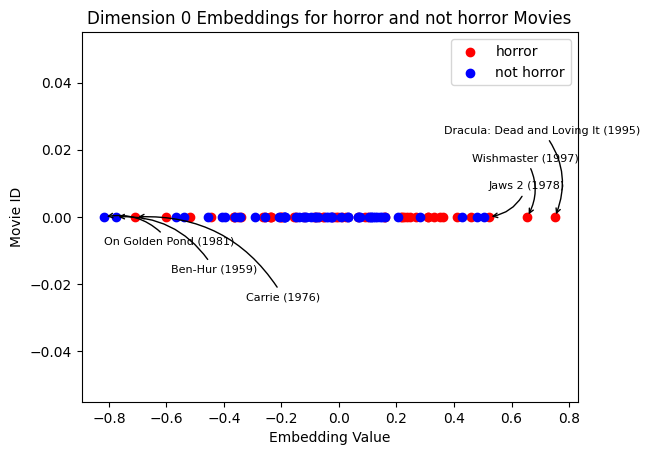

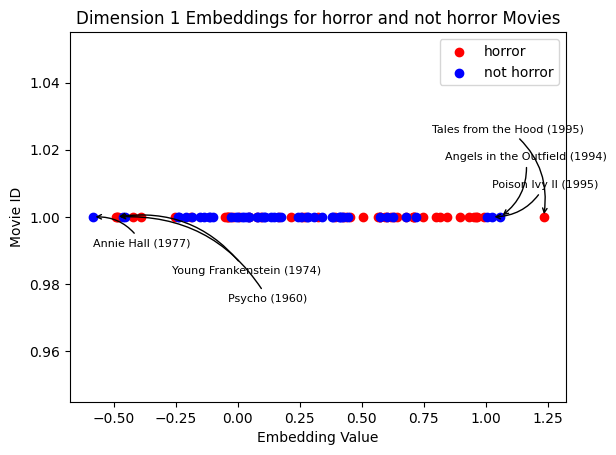

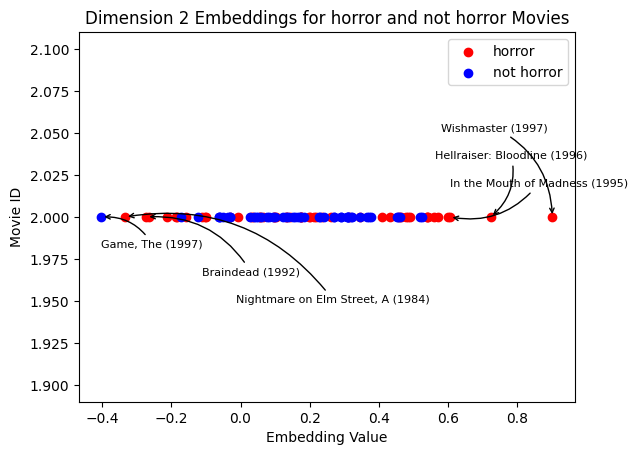

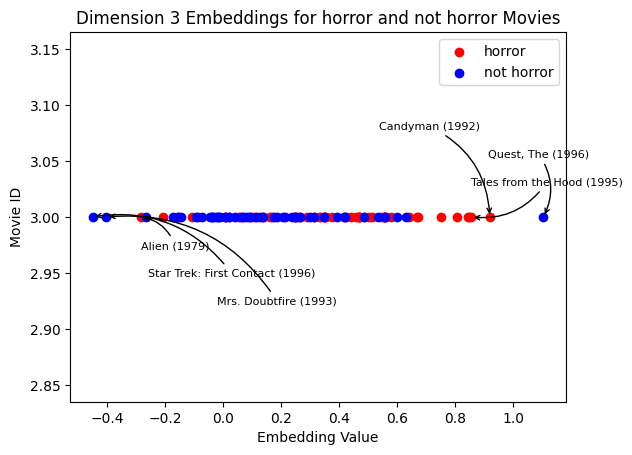

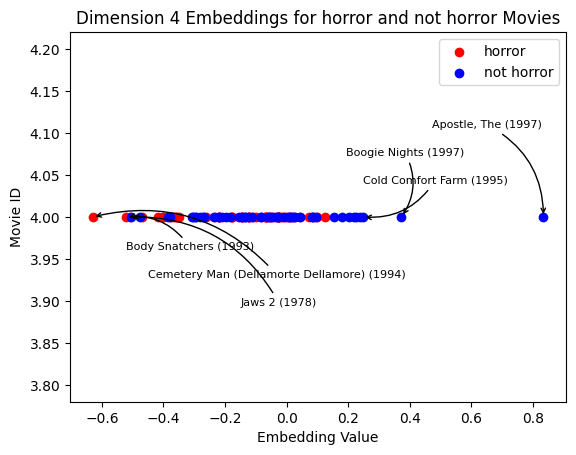

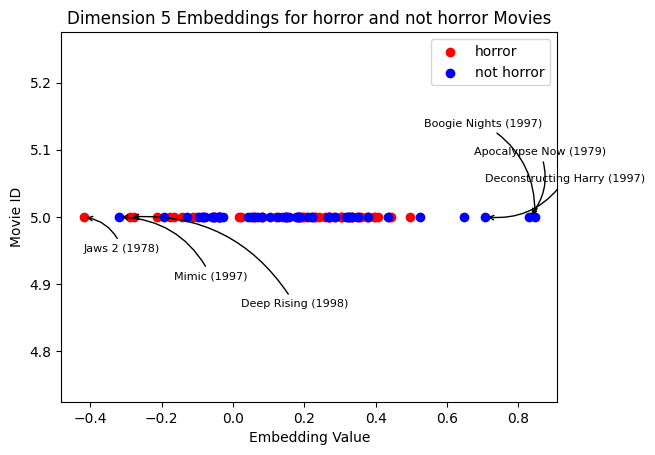

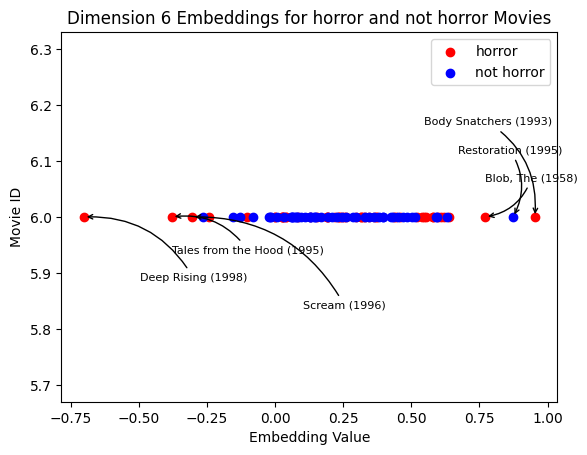

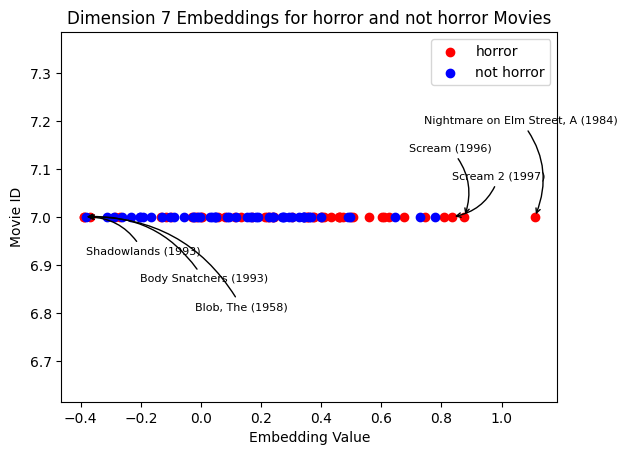

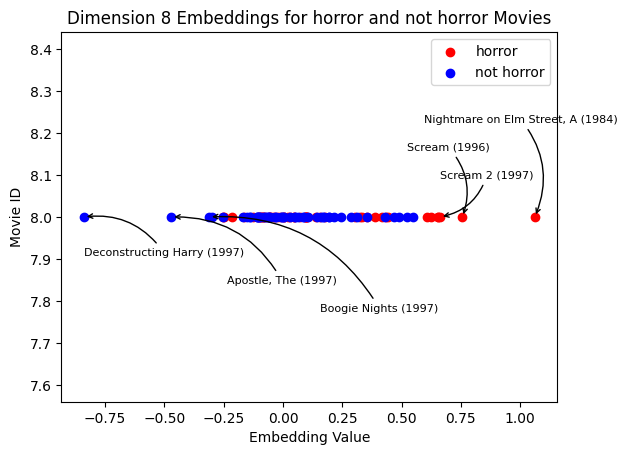

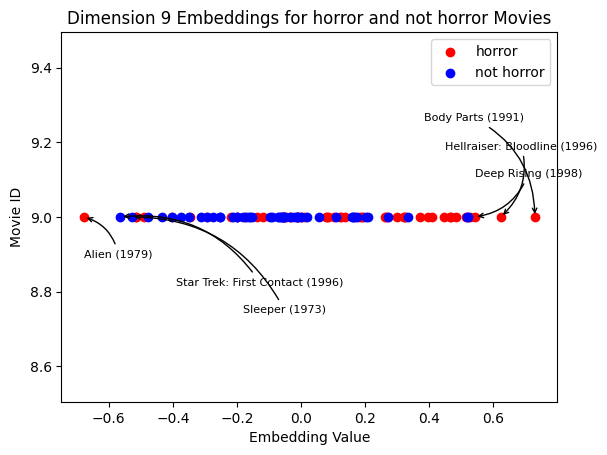

In [ ]:
plot_embs_one_genre(pmf.w_Item, moviesDF, "horror", 50)

I chose the "horror" genre and there were some small discernible differences between the horror movies and other movies embeddings. For example in dimension 8, the horror movies generally had higher embedding values than non-horror movies.

### Embedding plots for two genres

In [ ]:
def plot_embs_two_genres(embeddings, moviesDF, genres, sample_size):
  """
            INPUT:
                embeddings: numpy Array
                moviesDF: pandas DataFrame.
                          columns=['movieID',	'movieTitle',	'releaseDate	video','ReleaseDate',	'IMDbURL',...]
                genres: list of strings. (e.g., ['action', 'comedy'])
                sample_size: int


            OUTPUT:
                None

            NOTE: 1. You can read the file 'u.item' into a pandaas DataFrame for using as moviesDF
  """

  genre1 = genres[0]
  genre2 = genres[1]
  np.random.seed(3)
  genre1_movie_ids = np.random.choice(moviesDF[moviesDF[genre1] == 1]['movieID'].values, size = sample_size, replace=False)
  genre1_embeddings = embeddings[genre1_movie_ids]

  genre2_movie_ids = np.random.choice(moviesDF[moviesDF[genre2] == 1]['movieID'].values, size = sample_size, replace=False)
  genre2_embeddings = embeddings[genre2_movie_ids]

  all_ids = np.concatenate([genre1_movie_ids, genre2_movie_ids])
  index2id = {i:all_ids[i] for i in range(all_ids.shape[0])}

  all_embeddings = embeddings[all_ids]


  top_indices = np.argpartition(all_embeddings, -3, axis=0)[-3:]

  bottom_indices = np.argpartition(all_embeddings, 3, axis=0)[:3]

  v_offset = 20

  for i in range(embeddings.shape[1]):
    plt.close()
    plt.figure()
    plt.scatter(genre1_embeddings[:, i], np.full_like(genre1_movie_ids, i), c='red', label=f'{genre1}')
    plt.scatter(genre2_embeddings[:, i], np.full_like(genre2_movie_ids, i), c='blue', label=f'{genre2}')

    for k, j in enumerate(top_indices[:, i]):
      y_offset = k * v_offset
      plt.annotate(moviesDF.loc[moviesDF['movieID'] == index2id[j], 'movieTitle'].values[0], (all_embeddings[j, i], i ), xytext=(-2*y_offset, 20+i+y_offset), textcoords='offset points', fontsize=8, color='black', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.3' ,color='black'))

    for k, j in enumerate(bottom_indices[:, i]):
      y_offset = k * v_offset
      plt.annotate(moviesDF.loc[moviesDF['movieID'] == index2id[j], 'movieTitle'].values[0], (all_embeddings[j, i], i), xytext=(2*y_offset, -20-i-y_offset), textcoords='offset points', fontsize=8, color='black', arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=0.3', color='black'))

    plt.xlabel('Embedding Value')
    plt.ylabel('Movie ID')
    plt.legend()
    plt.title(f'Dimension {i} Embeddings for {genre1} and {genre2} Movies')
    plt.show()




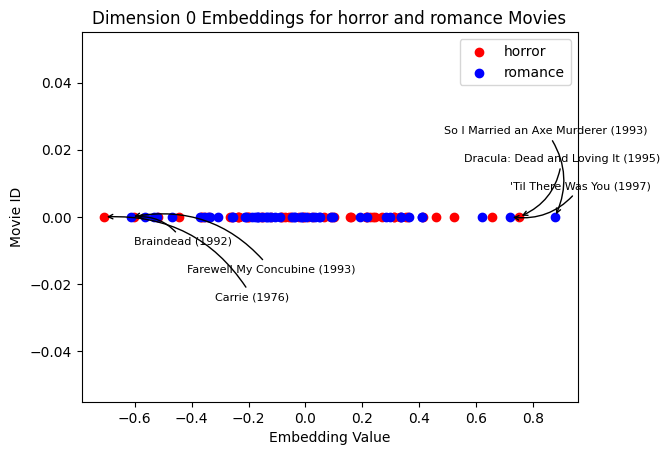

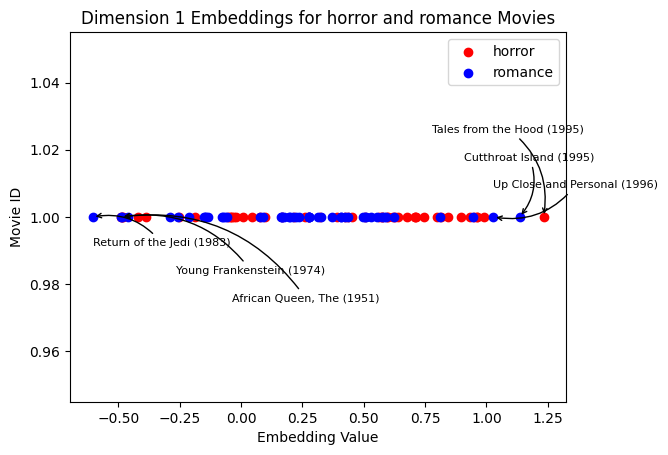

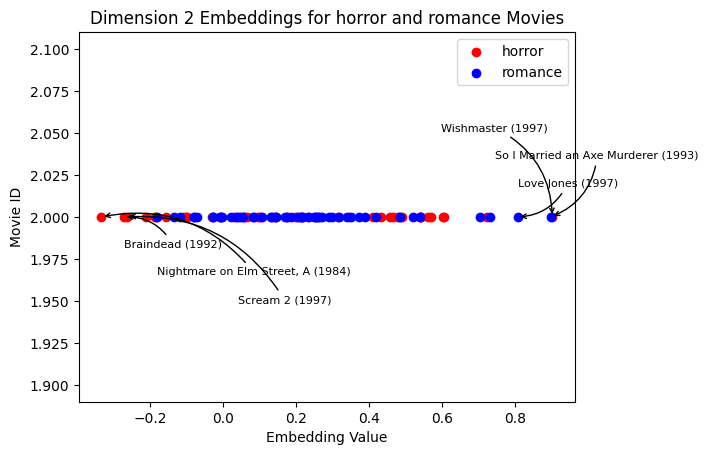

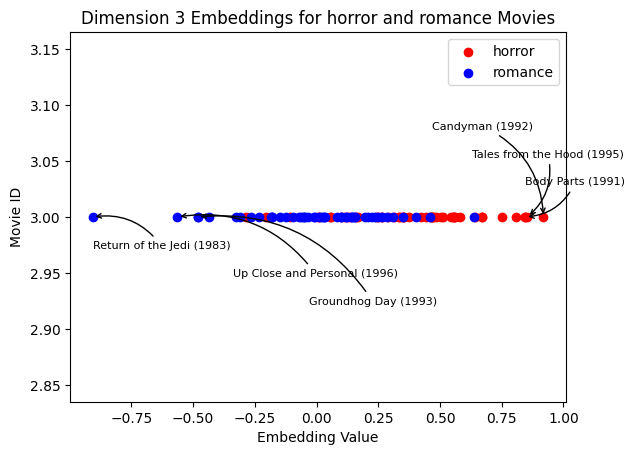

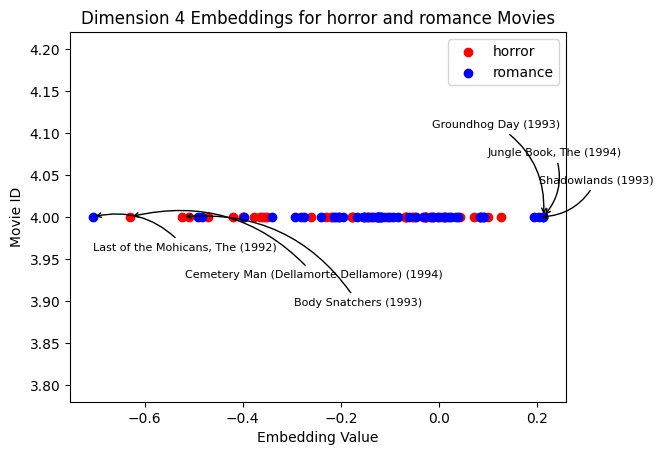

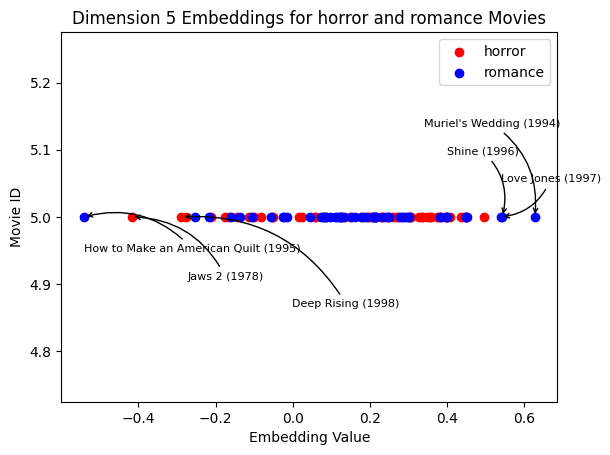

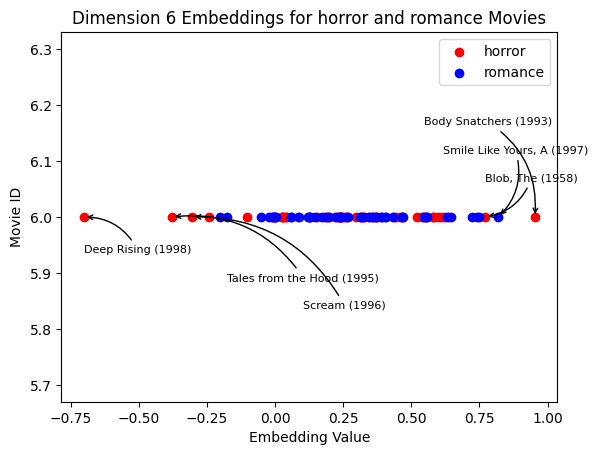

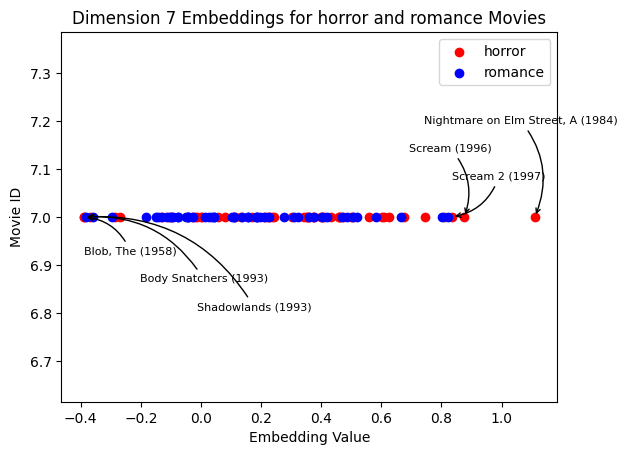

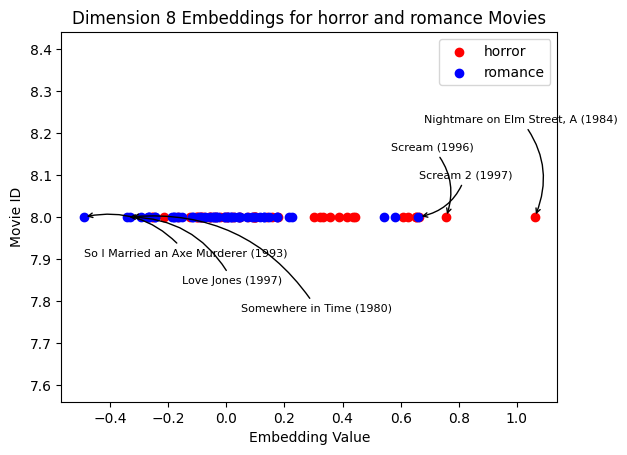

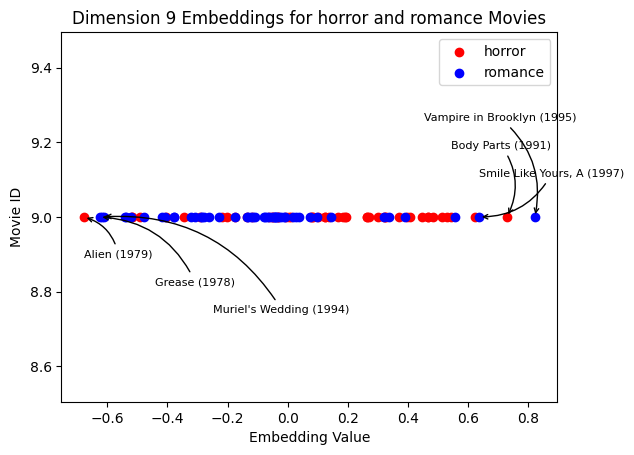

In [ ]:
plot_embs_two_genres(pmf.w_Item, moviesDF, ["horror", "romance"], 50)

Comparing the embeddings between the horror and romance genres we can see that there are some considerable differences in some of the dimensions. For example, in diminsion 6, horror movies have more lower values and romance movies have more higher values. Since these two genres are quite different, it makes sense that the embeddings of these genres would be different as well.

## Improved PMF

In [ ]:
class CompetitionRecSys(object):

    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
        Initialization of the class
        """
        self.pred_column_name = "PMF"

        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors

        self.rmse_train = []
        self.rmse_test = []

    def predict_all(self, train_vec, num_user, num_item):
        """
        INPUT:
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            num_user: scalar. number of users
            num_item: scalar. number of items
        OUTPUT:
            no return...

        NOTES:
            This function is where you train your model
        """
        # select 'userID', 'itemID', 'rating only
        train_vec['userID'] = train_vec['userID']
        train_vec['itemID'] = train_vec['itemID']
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating

        # to avoid out of bound
        num_user += 1
        num_item += 1

        # initialize epochs
        self.epoch = 0

        # Instead of random initialization, we use SVD
        # Construct the user-item matrix
        user_item_matrix = np.zeros((num_user, num_item))
        for i in range(train_vec.shape[0]):
            user_item_matrix[int(train_vec[i, 0]), int(train_vec[i, 1])] = train_vec[i, 2]
        # Apply SVD
        u, s, vT = svd(user_item_matrix, full_matrices=False, lapack_driver='gesvd')
        # Initialize the user and item weights
        self.w_User = u[:, :self.num_feat].dot(np.diag(np.sqrt(s[:self.num_feat])))
        self.w_Item = vT.T[:, :self.num_feat].dot(np.diag(np.sqrt(s[:self.num_feat])))

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient

        while self.epoch < self.maxepoch:
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches):
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')


                # Compute mean rating subtracted rating
                pred_out = None #size (batch_size, )
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :], self.w_Item[batch_ItemID, :]), axis=1)

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')

                    pred_out = None # size(pairs_train, )
                    pred_out = np.sum(np.multiply(self.w_User[train_user_idx, :], self.w_Item[train_item_idx, :]), axis=1)

                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2]
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')

                    # Compute Compute mean rating subtracted rating
                    pred_out = pred_out = None #size(pairs_val, )
                    pred_out = np.sum(np.multiply(self.w_User[val_user_idx, :], self.w_Item[val_item_idx, :]), axis=1)


                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))

    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame.
                              columns=['userID', 'itemID', 'rating', 'base-method'...]

            NOTES:
            This function is where your model makes prediction
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan

        for (index,
             userID,
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = None
            prediction.loc[index, self.pred_column_name] =  (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]

        return prediction

    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name

    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None
            self.w_User = None
            self.bias_User = None
            self.bias_Item = None
            self.rmse_train = []
            self.rmse_test = []
        except:
            print("You do not have w_Item, w_User")

    def plot_error(self):
        plt.plot(range(self.maxepoch), self.rmse_test, marker='v', label='Test Data')
        plt.plot(range(self.maxepoch), self.rmse_train, marker='o', label='Training Data')
        plt.title('The MovieLens Dataset Learning Curve')
        plt.xlabel('Number of Epochs')
        plt.ylabel('RMSE')
        plt.legend()
        plt.grid()
        plt.show()



In [ ]:
competition = CompetitionRecSys(num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=30, num_batches=30, batch_size=1000)
algorithm_instances = [competition]
cv_rp = CrossValidation('RPrecision')
rp = cv_rp.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
print(rp)

Processing algorithm PMF


20000it [00:03, 5000.51it/s]
20000it [00:04, 4983.37it/s]
20000it [00:04, 4475.58it/s]
20000it [00:04, 4984.13it/s]
20000it [00:04, 4965.19it/s]


{'PMF': [[0.7241307411288257, 0.7248181167638525, 0.7345868008979527, 0.7380805293315682, 0.7415003777965499], 0.7326233131837497, 0.7228961686265509, 0.7423504577409485]}


In [ ]:
competition = CompetitionRecSys(num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=30, num_batches=30, batch_size=1000)
algorithm_instances = [competition]
cv_rp = CrossValidation('RPrecision')
rp = cv_rp.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
print(rp)

Processing algorithm PMF


20000it [00:04, 4101.83it/s]
20000it [00:04, 4514.99it/s]
20000it [00:04, 4573.99it/s]
20000it [00:04, 4679.75it/s]
20000it [00:04, 4137.41it/s]


{'PMF': [[0.7257037577918276, 0.7236765041837283, 0.7259224471626275, 0.7371683529604465, 0.7400150748626267], 0.7304972273922514, 0.7211739601402574, 0.7398204946442455]}


Improved the PMF method by using SVD to get a better initialization of the latent user and item representations and then tuned the PMF hyperparameters to achieve an average RPrecision score of around 0.73.

RPrecision Mean: 0.7326233131837497

RPrecision CI: (0.7228961686265509, 0.7423504577409485)